<a href="https://www.kaggle.com/code/patimejia/contrails-init-data-stats-histograms?scriptVersionId=137081788" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [13]:
from utils_directory_tree_generator import get_directory_tree

base_directory = '/kaggle/input/google-research-identify-contrails-reduce-global-warming/test/'
os.makedirs('/kaggle/working/numpy_stats', exist_ok=True)

tree_generator = get_directory_tree(
    start_path=base_directory,  # Updated this line
    max_depth=4,
    include_files=True,
    sort_by='type',
    reverse=False,
    max_items=4
)
for line in tree_generator:
    print(line)



    1002653297254493116
        band_10.npy
        band_14.npy
        band_15.npy
        band_16.npy
    1000834164244036115
        band_10.npy
        band_14.npy
        band_15.npy
        band_16.npy


In [14]:
import os
import collections
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

def load_numpy_file(filepath):
    return np.load(filepath)

def calculate_statistics(data):
    mean = np.cumsum(data, dtype=float)[-1] / data.size if data.size > 0 else None
    hist, bins = np.histogram(data, bins=50)
    hist = hist / data.size
    return {
        'shape': data.shape,
        'size': data.size,
        'mean': mean,
        'std_dev': np.std(data),
        'min': np.min(data),
        'max': np.max(data),
        'median': np.median(data),
        'percentiles': np.percentile(data, [25, 50, 75]) if data.size > 0 else [None, None, None],
        'all_zeros': np.all(data == 0),
        'zero_count': np.count_nonzero(data == 0),
        'non_zero_count': np.count_nonzero(data),
        'has_nan': np.isnan(data).any(),
        'has_inf': np.isinf(data).any(),
        'histogram': (hist, bins)
    }

def generate_markdown_for_file(filepath, stats):
    markdown = f"### {filepath}\n\n"
    for stat, value in stats.items():
        markdown += f"* **{stat.capitalize()}**: {value}\n"
    markdown += '[Back to ToC](#table-of-contents)\n\n'
    return markdown

def process_file(filepath):
    try:
        data = load_numpy_file(filepath)
        stats = calculate_statistics(data)
        return filepath, generate_markdown_for_file(filepath, stats), stats['zero_count'] > 0
    except Exception as e:
        print(f"Error processing file {filepath}: {str(e)}")
        return None, None, None

def process_directory(directory_path):
    files_with_zeros = []
    files_without_zeros = []
    markdown_results = []
    for root, dirs, files in os.walk(directory_path):
        dirs[:] = [d for d in dirs if d not in ['test']]
        for file in files:
            filepath = os.path.join(root, file)
            if filepath.endswith('.npy'):
                filepath, markdown, has_zeros = process_file(filepath)
                if filepath is None:
                    continue
                if has_zeros:
                    files_with_zeros.append(filepath)
                else:
                    files_without_zeros.append(filepath)
                markdown_results.append(markdown)
    return markdown_results, files_with_zeros, files_without_zeros

def generate_markdown_section(title, items):
    section = f'## {title}\n\n'
    for item in items:
        section += f"* {item}\n"
    section += '[Back to ToC](#table-of-contents)\n\n'
    return section

def save_results(markdown_results, files_with_zeros, files_without_zeros):
    with open('/kaggle/working/numpy_stats/zeros_dataset_report.md', 'w') as results_file:
        results_file.write("## Summary\n\n")
        results_file.write(f"Total files: {len(markdown_results)}\n")
        results_file.write(f"Files with zeros: {len(files_with_zeros)}\n")
        results_file.write(f"Files without zeros: {len(files_without_zeros)}\n\n")
        for markdown in markdown_results:
            results_file.write(markdown)
        results_file.write(generate_markdown_section("Files with Zeros", files_with_zeros))
        results_file.write(generate_markdown_section("Files without Zeros", files_without_zeros))

def group_and_plot_histograms_by_dataset_record(directory_path, output_dir, histograms_per_row):
    results_by_dataset_record = collections.defaultdict(list)
    for root, dirs, files in os.walk(directory_path):
        for file in files:
            filepath = os.path.join(root, file)
            if filepath.endswith('.npy'):
                data = np.load(filepath)
                stats = calculate_statistics(data)
                dataset, record_id = filepath.split('/')[4:6]
                results_by_dataset_record[(dataset, record_id)].append((filepath, stats))

    dataset_records = list(results_by_dataset_record.keys())
    dataset_records.sort()

    num_histograms = len(dataset_records)
    num_rows = math.ceil(num_histograms / histograms_per_row)

    # Create a figure for bands
    fig = plt.figure(figsize=(15, num_rows * 7))
    for i, (dataset, record_id) in enumerate(dataset_records):
        record_results = results_by_dataset_record[(dataset, record_id)]
        band_results = [result for result in record_results if 'band_' in result[0].split('/')[-1]]
        colors = cm.viridis(np.linspace(0, 1, len(band_results)))
        ax = fig.add_subplot(num_rows, histograms_per_row, i+1)
        for color, (filepath, stats) in zip(colors, band_results):
            hist, bins = stats['histogram']
            ax.bar(bins[:-1], hist, width=np.diff(bins), ec="k", align="edge", alpha=0.5, label=os.path.basename(filepath), color=color)
        ax.set_title(f'Bands for record {record_id} in {dataset}')
        ax.grid(True)
        labels = [os.path.basename(filepath) for filepath, _ in band_results]
        ax.legend(labels, loc='upper left', bbox_to_anchor=(1, 1))
    output_filepath = os.path.join(output_dir, f'tiled_bands_histogram.png')
    fig.savefig(output_filepath)
    plt.close(fig)

    # Create a figure for masks
    fig = plt.figure(figsize=(15, num_rows * 7))
    for i, (dataset, record_id) in enumerate(dataset_records):
        record_results = results_by_dataset_record[(dataset, record_id)]
        mask_results = [result for result in record_results if 'human_' in result[0].split('/')[-1]]
        colors = cm.viridis(np.linspace(0, 1, len(mask_results)))
        ax = fig.add_subplot(num_rows, histograms_per_row, i+1)
        for color, (filepath, stats) in zip(colors, mask_results):
            hist, bins = stats['histogram']
            ax.bar(bins[:-1], hist, width=np.diff(bins), ec="k", align="edge", alpha=0.5, label=os.path.basename(filepath), color=color)
        ax.set_title(f'Masks for record {record_id} in {dataset}')
        ax.grid(True)
        labels = [os.path.basename(filepath) for filepath, _ in mask_results]
        ax.legend(labels, loc='upper left', bbox_to_anchor=(1, 1))
    output_filepath = os.path.join(output_dir, f'tiled_masks_histogram.png')
    fig.savefig(output_filepath)
    plt.close(fig)

# Main script
base_directory = '/kaggle/input/google-research-identify-contrails-reduce-global-warming/test/'
os.makedirs('/kaggle/working/numpy_stats', exist_ok=True)

try:
    markdown_results, files_with_zeros, files_without_zeros = process_directory(base_directory)
    save_results(markdown_results, files_with_zeros, files_without_zeros)
    group_and_plot_histograms_by_dataset_record(base_directory, '/kaggle/working/numpy_stats', 2)
except Exception as e:
    print(f"An error occurred: {str(e)}")

Usage:

1. For entire dataset:
   ```python
   base_directory = '/kaggle/input/google-research-identify-contrails-reduce-global-warming'
   ```
2. For 'test' only:
   ```python
   base_directory = '/kaggle/input/google-research-identify-contrails-reduce-global-warming/test'
   ```
3. Run code cell.
4. Wait for script completion.
5. Find output in:
   ```python
   '/kaggle/working/numpy_stats'
   ```
6. View files in Kaggle interface.

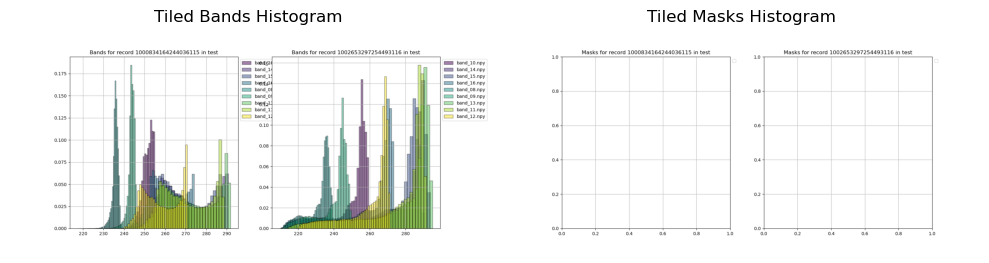

In [15]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Set figure size
fig = plt.figure(figsize=(10, 6))

# Display tiled_bands_histogram.png
ax1 = fig.add_subplot(121)
img_path = '/kaggle/working/numpy_stats/tiled_bands_histogram.png'
img = mpimg.imread(img_path)
imgplot = ax1.imshow(img)
ax1.axis('off')  # Hide axes
ax1.set_title('Tiled Bands Histogram')

# Display tiled_masks_histogram.png
ax2 = fig.add_subplot(122)
img_path = '/kaggle/working/numpy_stats/tiled_masks_histogram.png'
img = mpimg.imread(img_path)
imgplot = ax2.imshow(img)
ax2.axis('off')  # Hide axes
ax2.set_title('Tiled Masks Histogram')

plt.tight_layout()  # Adjust spacing between subplots
plt.show()


In [16]:
from IPython.display import Markdown

# Display contents of zeros_dataset_report.md
with open('/kaggle/working/numpy_stats/zeros_dataset_report.md', 'r') as f:
    markdown_content = f.read()
Markdown(markdown_content)


## Summary

Total files: 18
Files with zeros: 0
Files without zeros: 18

### /kaggle/input/google-research-identify-contrails-reduce-global-warming/test/1002653297254493116/band_10.npy

* **Shape**: (256, 256, 8)
* **Size**: 524288
* **Mean**: 248.82876050233608
* **Std_dev**: 11.444403648376465
* **Min**: 211.2795867919922
* **Max**: 265.919921875
* **Median**: 254.24832153320312
* **Percentiles**: [245.13962555 254.2483139  256.40771484]
* **All_zeros**: False
* **Zero_count**: 0
* **Non_zero_count**: 524288
* **Has_nan**: False
* **Has_inf**: False
* **Histogram**: (array([2.76565552e-04, 1.36375427e-03, 2.73323059e-03, 3.87763977e-03,
       4.88853455e-03, 5.58280945e-03, 5.67245483e-03, 6.33049011e-03,
       6.80732727e-03, 7.55500793e-03, 8.06999207e-03, 8.53538513e-03,
       9.23347473e-03, 9.23728943e-03, 9.43756104e-03, 9.45472717e-03,
       1.04598999e-02, 1.04122162e-02, 1.00498199e-02, 1.05762482e-02,
       1.03893280e-02, 1.00898743e-02, 9.85717773e-03, 9.56535339e-03,
       9.57298279e-03, 9.23538208e-03, 9.43946838e-03, 9.45854187e-03,
       1.00460052e-02, 1.03855133e-02, 1.16024017e-02, 1.44023895e-02,
       1.85337067e-02, 2.24304199e-02, 2.43835449e-02, 2.61631012e-02,
       2.66628265e-02, 3.08666229e-02, 5.86185455e-02, 9.85488892e-02,
       1.44134521e-01, 1.03816986e-01, 9.33551788e-02, 6.86702728e-02,
       1.65824890e-02, 1.98364258e-03, 3.43322754e-04, 1.29699707e-04,
       1.22070312e-04, 5.53131104e-05]), array([211.27959, 212.37239, 213.4652 , 214.55801, 215.65082, 216.74362,
       217.83643, 218.92923, 220.02203, 221.11485, 222.20766, 223.30046,
       224.39326, 225.48607, 226.57889, 227.67169, 228.7645 , 229.8573 ,
       230.9501 , 232.04291, 233.13573, 234.22853, 235.32133, 236.41414,
       237.50694, 238.59976, 239.69257, 240.78537, 241.87817, 242.97098,
       244.06378, 245.1566 , 246.2494 , 247.34221, 248.43501, 249.52782,
       250.62062, 251.71344, 252.80624, 253.89905, 254.99185, 256.08466,
       257.17746, 258.27026, 259.36307, 260.4559 , 261.5487 , 262.6415 ,
       263.7343 , 264.82712, 265.91992], dtype=float32))
[Back to ToC](#table-of-contents)

### /kaggle/input/google-research-identify-contrails-reduce-global-warming/test/1002653297254493116/band_14.npy

* **Shape**: (256, 256, 8)
* **Size**: 524288
* **Mean**: 273.90562600645353
* **Std_dev**: 21.20493507385254
* **Min**: 211.59524536132812
* **Max**: 293.8205871582031
* **Median**: 284.77545166015625
* **Percentiles**: [264.73403168 284.77546692 289.10406494]
* **All_zeros**: False
* **Zero_count**: 0
* **Non_zero_count**: 524288
* **Has_nan**: False
* **Has_inf**: False
* **Histogram**: (array([0.00052261, 0.00279617, 0.00486183, 0.00595856, 0.00633621,
       0.00657463, 0.00731659, 0.00800896, 0.00808144, 0.00837326,
       0.00849915, 0.0083046 , 0.00831413, 0.00812912, 0.00797844,
       0.00817299, 0.00819778, 0.00860786, 0.00843811, 0.00769424,
       0.00832748, 0.00862312, 0.0087719 , 0.00817871, 0.00819016,
       0.00843811, 0.00820732, 0.00850868, 0.00878716, 0.00915909,
       0.00996017, 0.01029778, 0.01140976, 0.01251221, 0.01410103,
       0.01490021, 0.01673508, 0.01874161, 0.01928902, 0.02014351,
       0.02093124, 0.02219009, 0.02534485, 0.03335762, 0.05552483,
       0.08631516, 0.1128273 , 0.14316368, 0.09123611, 0.03466034]), array([211.59525, 213.23975, 214.88426, 216.52876, 218.17328, 219.81778,
       221.46228, 223.1068 , 224.7513 , 226.39581, 228.04031, 229.68481,
       231.32933, 232.97383, 234.61835, 236.26285, 237.90735, 239.55186,
       241.19637, 242.84088, 244.48538, 246.12988, 247.7744 , 249.4189 ,
       251.06342, 252.70792, 254.35242, 255.99693, 257.64145, 259.28595,
       260.93045, 262.57495, 264.21945, 265.86398, 267.50848, 269.15298,
       270.7975 , 272.442  , 274.08652, 275.73102, 277.37552, 279.02002,
       280.66452, 282.30905, 283.95355, 285.59805, 287.24255, 288.88705,
       290.5316 , 292.1761 , 293.8206 ], dtype=float32))
[Back to ToC](#table-of-contents)

### /kaggle/input/google-research-identify-contrails-reduce-global-warming/test/1002653297254493116/band_15.npy

* **Shape**: (256, 256, 8)
* **Size**: 524288
* **Mean**: 269.9724259117502
* **Std_dev**: 21.062767028808594
* **Min**: 210.42147827148438
* **Max**: 290.4158630371094
* **Median**: 280.79638671875
* **Percentiles**: [260.25856781 280.79637146 285.20090485]
* **All_zeros**: False
* **Zero_count**: 0
* **Non_zero_count**: 524288
* **Has_nan**: False
* **Has_inf**: False
* **Histogram**: (array([0.00069809, 0.00352859, 0.00579262, 0.00711632, 0.00726318,
       0.00777626, 0.00861168, 0.00871468, 0.0090847 , 0.00923157,
       0.00886536, 0.00886154, 0.00854301, 0.00836754, 0.0086689 ,
       0.00880623, 0.00882721, 0.00828552, 0.00811958, 0.00890923,
       0.00883293, 0.00826073, 0.00801086, 0.00800896, 0.00809479,
       0.00798988, 0.0083313 , 0.008255  , 0.00884819, 0.00960541,
       0.01019096, 0.01086426, 0.01182938, 0.01286697, 0.01449585,
       0.01617241, 0.01809502, 0.0182724 , 0.01887894, 0.01886559,
       0.01904488, 0.02087021, 0.02692223, 0.04510307, 0.0721817 ,
       0.08891106, 0.12547493, 0.11695099, 0.08069992, 0.01499939]), array([210.42148, 212.02136, 213.62125, 215.22115, 216.82103, 218.42091,
       220.0208 , 221.6207 , 223.22058, 224.82047, 226.42035, 228.02025,
       229.62013, 231.22002, 232.8199 , 234.4198 , 236.01968, 237.61957,
       239.21945, 240.81935, 242.41924, 244.01912, 245.619  , 247.2189 ,
       248.81879, 250.41867, 252.01855, 253.61844, 255.21834, 256.8182 ,
       258.41812, 260.018  , 261.6179 , 263.21777, 264.81766, 266.41754,
       268.01743, 269.6173 , 271.21722, 272.8171 , 274.417  , 276.01688,
       277.61676, 279.21664, 280.81653, 282.4164 , 284.01633, 285.6162 ,
       287.2161 , 288.81598, 290.41586], dtype=float32))
[Back to ToC](#table-of-contents)

### /kaggle/input/google-research-identify-contrails-reduce-global-warming/test/1002653297254493116/band_16.npy

* **Shape**: (256, 256, 8)
* **Size**: 524288
* **Mean**: 257.92528985539684
* **Std_dev**: 17.2115478515625
* **Min**: 210.474609375
* **Max**: 274.65771484375
* **Median**: 266.8360290527344
* **Percentiles**: [249.48088837 266.83602905 270.47958374]
* **All_zeros**: False
* **Zero_count**: 0
* **Non_zero_count**: 524288
* **Has_nan**: False
* **Has_inf**: False
* **Histogram**: (array([0.00067329, 0.00343513, 0.00598717, 0.00776672, 0.00797653,
       0.00861549, 0.00912857, 0.00951958, 0.00964928, 0.00980949,
       0.00954247, 0.0093708 , 0.0088501 , 0.0092926 , 0.0093956 ,
       0.00895882, 0.00874901, 0.00878525, 0.00914192, 0.00857353,
       0.00820923, 0.00797844, 0.00791931, 0.00790024, 0.0078907 ,
       0.00790215, 0.00787735, 0.00817108, 0.00918961, 0.00977325,
       0.01032448, 0.0108242 , 0.01159286, 0.0133934 , 0.01506233,
       0.01636505, 0.01727486, 0.01747894, 0.01747513, 0.01726151,
       0.01796722, 0.01946068, 0.02851677, 0.04606438, 0.06979179,
       0.08517075, 0.12537766, 0.11618042, 0.08395958, 0.01442528]), array([210.47461, 211.75827, 213.04193, 214.32559, 215.60925, 216.89291,
       218.17657, 219.46025, 220.74391, 222.02757, 223.31123, 224.5949 ,
       225.87856, 227.16222, 228.44588, 229.72954, 231.0132 , 232.29686,
       233.58052, 234.8642 , 236.14786, 237.43152, 238.71518, 239.99884,
       241.2825 , 242.56616, 243.84982, 245.13348, 246.41714, 247.7008 ,
       248.98447, 250.26813, 251.5518 , 252.83546, 254.11913, 255.40279,
       256.68643, 257.9701 , 259.25378, 260.53745, 261.8211 , 263.10477,
       264.38843, 265.6721 , 266.95575, 268.2394 , 269.52307, 270.80673,
       272.0904 , 273.37405, 274.6577 ], dtype=float32))
[Back to ToC](#table-of-contents)

### /kaggle/input/google-research-identify-contrails-reduce-global-warming/test/1002653297254493116/band_08.npy

* **Shape**: (256, 256, 8)
* **Size**: 524288
* **Mean**: 231.57845466933213
* **Std_dev**: 6.768033504486084
* **Min**: 209.64309692382812
* **Max**: 242.36346435546875
* **Median**: 234.40443420410156
* **Percentiles**: [228.77297974 234.4044342  236.26690674]
* **All_zeros**: False
* **Zero_count**: 0
* **Non_zero_count**: 524288
* **Has_nan**: False
* **Has_inf**: False
* **Histogram**: (array([7.62939453e-05, 5.03540039e-04, 1.37901306e-03, 2.54249573e-03,
       3.58200073e-03, 4.92858887e-03, 5.99861145e-03, 6.54983521e-03,
       7.50541687e-03, 8.47244263e-03, 8.58688354e-03, 9.21058655e-03,
       1.01833344e-02, 1.05304718e-02, 1.16271973e-02, 1.21631622e-02,
       1.25350952e-02, 1.23958588e-02, 1.22089386e-02, 1.13410950e-02,
       1.08222961e-02, 1.06620789e-02, 1.04961395e-02, 1.03149414e-02,
       1.01299286e-02, 9.91058350e-03, 1.02157593e-02, 1.06258392e-02,
       1.15737915e-02, 1.37367249e-02, 1.76486969e-02, 2.10113525e-02,
       2.24170685e-02, 2.36740112e-02, 2.34165192e-02, 2.90336609e-02,
       4.59728241e-02, 6.92806244e-02, 8.51020813e-02, 8.88004303e-02,
       8.96148682e-02, 7.81116486e-02, 5.99689484e-02, 3.93524170e-02,
       3.19881439e-02, 1.00288391e-02, 2.00653076e-03, 1.14631653e-03,
       4.73022461e-04, 1.43051147e-04]), array([209.6431 , 210.2975 , 210.9519 , 211.60632, 212.26073, 212.91513,
       213.56953, 214.22395, 214.87836, 215.53276, 216.18716, 216.84158,
       217.49599, 218.15039, 218.8048 , 219.45921, 220.11362, 220.76802,
       221.42242, 222.07684, 222.73125, 223.38565, 224.04005, 224.69447,
       225.34888, 226.00328, 226.65768, 227.31209, 227.9665 , 228.62091,
       229.27531, 229.92972, 230.58414, 231.23854, 231.89294, 232.54735,
       233.20177, 233.85617, 234.51057, 235.16498, 235.8194 , 236.4738 ,
       237.1282 , 237.78261, 238.43703, 239.09143, 239.74583, 240.40024,
       241.05466, 241.70906, 242.36346], dtype=float32))
[Back to ToC](#table-of-contents)

### /kaggle/input/google-research-identify-contrails-reduce-global-warming/test/1002653297254493116/band_09.npy

* **Shape**: (256, 256, 8)
* **Size**: 524288
* **Mean**: 239.74080838635564
* **Std_dev**: 8.969274520874023
* **Min**: 210.49171447753906
* **Max**: 255.10675048828125
* **Median**: 243.6463623046875
* **Percentiles**: [236.52803421 243.64635468 245.67095947]
* **All_zeros**: False
* **Zero_count**: 0
* **Non_zero_count**: 524288
* **Has_nan**: False
* **Has_inf**: False
* **Histogram**: (array([1.86920166e-04, 1.01470947e-03, 2.29263306e-03, 3.41796875e-03,
       4.59480286e-03, 5.77545166e-03, 6.10923767e-03, 6.81686401e-03,
       7.71522522e-03, 8.04519653e-03, 8.81195068e-03, 9.56153870e-03,
       1.03549957e-02, 1.06849670e-02, 1.13735199e-02, 1.17721558e-02,
       1.15375519e-02, 1.19132996e-02, 1.14612579e-02, 1.05094910e-02,
       1.04217529e-02, 1.06544495e-02, 1.01642609e-02, 9.60922241e-03,
       9.65309143e-03, 9.85717773e-03, 1.03416443e-02, 1.07517242e-02,
       1.21974945e-02, 1.50299072e-02, 1.89571381e-02, 2.20909119e-02,
       2.36034393e-02, 2.48279572e-02, 2.61821747e-02, 3.77750397e-02,
       7.01923370e-02, 9.70115662e-02, 1.26054764e-01, 8.61225128e-02,
       8.24279785e-02, 5.21106720e-02, 4.30202484e-02, 1.71184540e-02,
       5.11741638e-03, 2.71797180e-03, 1.35231018e-03, 5.13076782e-04,
       1.33514404e-04, 4.00543213e-05]), array([210.49171, 211.38402, 212.27632, 213.16861, 214.06091, 214.95322,
       215.84552, 216.73782, 217.63013, 218.52242, 219.41472, 220.30702,
       221.19933, 222.09163, 222.98392, 223.87622, 224.76852, 225.66083,
       226.55313, 227.44543, 228.33772, 229.23003, 230.12233, 231.01463,
       231.90694, 232.79922, 233.69153, 234.58383, 235.47614, 236.36844,
       237.26074, 238.15303, 239.04533, 239.93764, 240.82994, 241.72224,
       242.61455, 243.50684, 244.39914, 245.29144, 246.18375, 247.07605,
       247.96834, 248.86064, 249.75294, 250.64525, 251.53755, 252.42986,
       253.32214, 254.21445, 255.10675], dtype=float32))
[Back to ToC](#table-of-contents)

### /kaggle/input/google-research-identify-contrails-reduce-global-warming/test/1002653297254493116/band_13.npy

* **Shape**: (256, 256, 8)
* **Size**: 524288
* **Mean**: 276.9032906597713
* **Std_dev**: 20.013086318969727
* **Min**: 213.48106384277344
* **Max**: 295.03533935546875
* **Median**: 287.1636047363281
* **Percentiles**: [269.23300171 287.16360474 290.91251373]
* **All_zeros**: False
* **Zero_count**: 0
* **Non_zero_count**: 524288
* **Has_nan**: False
* **Has_inf**: False
* **Histogram**: (array([0.00026512, 0.00175285, 0.00324059, 0.00438499, 0.00475693,
       0.00498199, 0.00531387, 0.00593185, 0.00636673, 0.00673676,
       0.00711632, 0.00741005, 0.00767899, 0.00758934, 0.00764275,
       0.0077095 , 0.00769997, 0.00782776, 0.00789833, 0.00815201,
       0.00845528, 0.00802994, 0.00780487, 0.00846863, 0.0088768 ,
       0.00911903, 0.00872993, 0.00885391, 0.00891304, 0.00901604,
       0.00951004, 0.00994873, 0.01050568, 0.0113163 , 0.01259232,
       0.01445389, 0.01628304, 0.01745605, 0.01917648, 0.02115059,
       0.02316093, 0.02523994, 0.02654839, 0.02887344, 0.03845406,
       0.06774521, 0.11960983, 0.15588951, 0.11919212, 0.04616928]), array([213.48106, 215.11215, 216.74324, 218.37431, 220.0054 , 221.63649,
       223.26758, 224.89867, 226.52975, 228.16083, 229.79192, 231.423  ,
       233.0541 , 234.68518, 236.31625, 237.94734, 239.57843, 241.20952,
       242.8406 , 244.4717 , 246.10277, 247.73386, 249.36494, 250.99603,
       252.62712, 254.25821, 255.88928, 257.5204 , 259.15146, 260.78253,
       262.41364, 264.0447 , 265.6758 , 267.3069 , 268.93796, 270.56906,
       272.20013, 273.83124, 275.4623 , 277.09338, 278.7245 , 280.35556,
       281.98666, 283.61774, 285.24884, 286.8799 , 288.511  , 290.1421 ,
       291.77316, 293.40427, 295.03534], dtype=float32))
[Back to ToC](#table-of-contents)

### /kaggle/input/google-research-identify-contrails-reduce-global-warming/test/1002653297254493116/band_11.npy

* **Shape**: (256, 256, 8)
* **Size**: 524288
* **Mean**: 275.03686615955667
* **Std_dev**: 18.844661712646484
* **Min**: 212.91720581054688
* **Max**: 291.66796875
* **Median**: 284.6396484375
* **Percentiles**: [268.50241852 284.63963318 288.04981232]
* **All_zeros**: False
* **Zero_count**: 0
* **Non_zero_count**: 524288
* **Has_nan**: False
* **Has_inf**: False
* **Histogram**: (array([0.00030518, 0.00162888, 0.00275803, 0.00375938, 0.0042057 ,
       0.00447655, 0.00463867, 0.00495529, 0.00564766, 0.00572968,
       0.00642395, 0.00656128, 0.00692749, 0.00702667, 0.00725746,
       0.00716782, 0.00746155, 0.00754166, 0.00754356, 0.00760841,
       0.00793266, 0.00820541, 0.00826454, 0.00775528, 0.00825882,
       0.008955  , 0.00925636, 0.0087986 , 0.00899506, 0.00905418,
       0.00932121, 0.00963593, 0.01004219, 0.01079178, 0.01156807,
       0.01307297, 0.01523018, 0.01730156, 0.01889992, 0.02086639,
       0.02345657, 0.02563477, 0.0282383 , 0.02993584, 0.03510284,
       0.05714417, 0.11043358, 0.1580143 , 0.14970207, 0.05050659]), array([212.9172 , 214.49222, 216.06723, 217.64226, 219.21727, 220.79228,
       222.3673 , 223.9423 , 225.51733, 227.09235, 228.66736, 230.24237,
       231.81738, 233.39241, 234.96742, 236.54243, 238.11745, 239.69246,
       241.26749, 242.8425 , 244.41751, 245.99252, 247.56754, 249.14256,
       250.71758, 252.29259, 253.8676 , 255.44261, 257.01764, 258.59265,
       260.16766, 261.74268, 263.3177 , 264.8927 , 266.4677 , 268.04272,
       269.61777, 271.19278, 272.7678 , 274.3428 , 275.91782, 277.49283,
       279.06784, 280.64285, 282.21786, 283.7929 , 285.36792, 286.94293,
       288.51794, 290.09296, 291.66797], dtype=float32))
[Back to ToC](#table-of-contents)

### /kaggle/input/google-research-identify-contrails-reduce-global-warming/test/1002653297254493116/band_12.npy

* **Shape**: (256, 256, 8)
* **Size**: 524288
* **Mean**: 259.1632369531435
* **Std_dev**: 12.927360534667969
* **Min**: 219.3023681640625
* **Max**: 271.2978210449219
* **Median**: 265.6063232421875
* **Percentiles**: [253.80823898 265.6063385  268.4543457 ]
* **All_zeros**: False
* **Zero_count**: 0
* **Non_zero_count**: 524288
* **Has_nan**: False
* **Has_inf**: False
* **Histogram**: (array([0.00056648, 0.0025425 , 0.00414276, 0.0048008 , 0.00515938,
       0.00524139, 0.00561142, 0.00648117, 0.00673866, 0.00716972,
       0.00738716, 0.00757217, 0.00782585, 0.00782013, 0.00786591,
       0.00790405, 0.00798607, 0.00789261, 0.00810432, 0.00817108,
       0.00836182, 0.00782204, 0.00820732, 0.00868225, 0.00921059,
       0.0090847 , 0.00895309, 0.00921249, 0.00919533, 0.00969505,
       0.01024628, 0.01070213, 0.01145935, 0.01292801, 0.01473236,
       0.01600838, 0.01712608, 0.01891708, 0.02170753, 0.022686  ,
       0.02411079, 0.02553368, 0.0268364 , 0.03069878, 0.04515839,
       0.07085419, 0.11827087, 0.14669609, 0.10539818, 0.0345211 ]), array([219.30237, 220.34227, 221.38219, 222.42209, 223.462  , 224.5019 ,
       225.54182, 226.58173, 227.62164, 228.66154, 229.70146, 230.74136,
       231.78128, 232.82118, 233.8611 , 234.901  , 235.94092, 236.98082,
       238.02074, 239.06064, 240.10056, 241.14046, 242.18037, 243.22028,
       244.2602 , 245.3001 , 246.34   , 247.37991, 248.41982, 249.45973,
       250.49963, 251.53955, 252.57945, 253.61937, 254.65927, 255.69919,
       256.7391 , 257.779  , 258.8189 , 259.85883, 260.89874, 261.93863,
       262.97855, 264.01846, 265.05838, 266.09827, 267.13818, 268.1781 ,
       269.21802, 270.2579 , 271.29782], dtype=float32))
[Back to ToC](#table-of-contents)

### /kaggle/input/google-research-identify-contrails-reduce-global-warming/test/1000834164244036115/band_10.npy

* **Shape**: (256, 256, 8)
* **Size**: 524288
* **Mean**: 251.42457374293008
* **Std_dev**: 2.7326555252075195
* **Min**: 219.58058166503906
* **Max**: 255.59690856933594
* **Median**: 251.8728790283203
* **Percentiles**: [249.77569199 251.87287903 253.52368164]
* **All_zeros**: False
* **Zero_count**: 0
* **Non_zero_count**: 524288
* **Has_nan**: False
* **Has_inf**: False
* **Histogram**: (array([3.81469727e-06, 0.00000000e+00, 7.62939453e-06, 3.81469727e-06,
       3.81469727e-06, 9.53674316e-06, 1.14440918e-05, 9.53674316e-06,
       1.14440918e-05, 7.62939453e-06, 1.90734863e-05, 1.71661377e-05,
       1.14440918e-05, 2.67028809e-05, 1.14440918e-05, 1.52587891e-05,
       3.24249268e-05, 2.67028809e-05, 2.28881836e-05, 3.24249268e-05,
       8.58306885e-05, 1.12533569e-04, 1.31607056e-04, 1.81198120e-04,
       1.90734863e-04, 2.76565552e-04, 3.58581543e-04, 5.45501709e-04,
       8.04901123e-04, 1.15394592e-03, 1.60408020e-03, 2.19345093e-03,
       3.26156616e-03, 4.41360474e-03, 6.10351562e-03, 9.65690613e-03,
       1.42879486e-02, 1.89895630e-02, 2.54688263e-02, 3.14998627e-02,
       5.41248322e-02, 8.12492371e-02, 8.44554901e-02, 8.30001831e-02,
       9.07268524e-02, 9.66033936e-02, 1.22669220e-01, 1.10288620e-01,
       1.09348297e-01, 4.59289551e-02]), array([219.58058, 220.3009 , 221.02124, 221.74156, 222.46188, 223.18222,
       223.90254, 224.62286, 225.3432 , 226.06352, 226.78384, 227.50418,
       228.2245 , 228.94482, 229.66515, 230.38548, 231.1058 , 231.82613,
       232.54646, 233.26678, 233.9871 , 234.70744, 235.42776, 236.14809,
       236.86842, 237.58875, 238.30907, 239.0294 , 239.74973, 240.47005,
       241.19038, 241.9107 , 242.63103, 243.35136, 244.07169, 244.792  ,
       245.51234, 246.23267, 246.95299, 247.67331, 248.39365, 249.11397,
       249.83429, 250.55463, 251.27495, 251.99527, 252.7156 , 253.43593,
       254.15625, 254.87659, 255.59691], dtype=float32))
[Back to ToC](#table-of-contents)

### /kaggle/input/google-research-identify-contrails-reduce-global-warming/test/1000834164244036115/band_14.npy

* **Shape**: (256, 256, 8)
* **Size**: 524288
* **Mean**: 271.33806114117033
* **Std_dev**: 11.806071281433105
* **Min**: 221.86102294921875
* **Max**: 290.6600646972656
* **Median**: 269.46490478515625
* **Percentiles**: [261.07318115 269.46488953 282.89597321]
* **All_zeros**: False
* **Zero_count**: 0
* **Non_zero_count**: 524288
* **Has_nan**: False
* **Has_inf**: False
* **Histogram**: (array([3.81469727e-06, 3.81469727e-06, 3.81469727e-06, 7.62939453e-06,
       7.62939453e-06, 1.14440918e-05, 1.33514404e-05, 9.53674316e-06,
       1.33514404e-05, 2.47955322e-05, 4.00543213e-05, 9.53674316e-05,
       1.16348267e-04, 1.16348267e-04, 1.25885010e-04, 1.10626221e-04,
       3.35693359e-04, 7.13348389e-04, 1.88636780e-03, 3.24249268e-03,
       4.41932678e-03, 9.69505310e-03, 1.35383606e-02, 1.76582336e-02,
       2.28099823e-02, 3.83815765e-02, 5.72280884e-02, 5.46722412e-02,
       4.86125946e-02, 4.82292175e-02, 4.33578491e-02, 3.92627716e-02,
       3.73420715e-02, 3.72886658e-02, 3.37562561e-02, 3.02276611e-02,
       2.86369324e-02, 2.68592834e-02, 2.48241425e-02, 2.37808228e-02,
       2.32944489e-02, 2.30083466e-02, 2.27279663e-02, 2.42557526e-02,
       2.64472961e-02, 2.84557343e-02, 3.60908508e-02, 4.75883484e-02,
       5.88703156e-02, 6.17980957e-02]), array([221.86102, 223.237  , 224.61299, 225.98897, 227.36494, 228.74092,
       230.11691, 231.49289, 232.86887, 234.24486, 235.62083, 236.99681,
       238.37279, 239.74878, 241.12476, 242.50073, 243.87671, 245.2527 ,
       246.62868, 248.00465, 249.38065, 250.75662, 252.1326 , 253.50858,
       254.88457, 256.26056, 257.63654, 259.0125 , 260.3885 , 261.76447,
       263.14044, 264.51642, 265.8924 , 267.2684 , 268.64438, 270.02036,
       271.39633, 272.7723 , 274.1483 , 275.52426, 276.90027, 278.27625,
       279.65222, 281.0282 , 282.40417, 283.78015, 285.15613, 286.53214,
       287.9081 , 289.2841 , 290.66006], dtype=float32))
[Back to ToC](#table-of-contents)

### /kaggle/input/google-research-identify-contrails-reduce-global-warming/test/1000834164244036115/band_15.npy

* **Shape**: (256, 256, 8)
* **Size**: 524288
* **Mean**: 268.69265907790395
* **Std_dev**: 10.894463539123535
* **Min**: 220.5182342529297
* **Max**: 287.3263244628906
* **Median**: 266.746826171875
* **Percentiles**: [259.51351929 266.74684143 278.96224213]
* **All_zeros**: False
* **Zero_count**: 0
* **Non_zero_count**: 524288
* **Has_nan**: False
* **Has_inf**: False
* **Histogram**: (array([3.81469727e-06, 5.72204590e-06, 9.53674316e-06, 3.81469727e-06,
       9.53674316e-06, 1.71661377e-05, 7.62939453e-06, 1.33514404e-05,
       2.28881836e-05, 1.33514404e-05, 5.34057617e-05, 8.96453857e-05,
       1.04904175e-04, 1.35421753e-04, 1.18255615e-04, 1.16348267e-04,
       2.34603882e-04, 5.76019287e-04, 1.06811523e-03, 2.13050842e-03,
       3.68118286e-03, 4.89997864e-03, 9.94873047e-03, 1.48315430e-02,
       1.98497772e-02, 2.49271393e-02, 3.56407166e-02, 5.94730377e-02,
       6.16168976e-02, 5.39512634e-02, 5.30185699e-02, 4.80403900e-02,
       4.23545837e-02, 3.94287109e-02, 3.93943787e-02, 3.65886688e-02,
       3.12328339e-02, 2.91461945e-02, 2.65502930e-02, 2.45532990e-02,
       2.31704712e-02, 2.23960876e-02, 2.27680206e-02, 2.41603851e-02,
       2.55527496e-02, 2.88925171e-02, 3.71074677e-02, 4.28695679e-02,
       4.81529236e-02, 6.10675812e-02]), array([220.51823, 221.8544 , 223.19055, 224.52672, 225.86288, 227.19904,
       228.5352 , 229.87137, 231.20753, 232.54369, 233.87985, 235.21602,
       236.55217, 237.88834, 239.2245 , 240.56067, 241.89682, 243.23299,
       244.56915, 245.9053 , 247.24147, 248.57764, 249.91379, 251.24995,
       252.58612, 253.92227, 255.25844, 256.5946 , 257.93076, 259.26694,
       260.6031 , 261.93924, 263.27542, 264.61157, 265.94772, 267.2839 ,
       268.62006, 269.9562 , 271.2924 , 272.62854, 273.96472, 275.30087,
       276.63702, 277.9732 , 279.30936, 280.6455 , 281.9817 , 283.31784,
       284.654  , 285.99017, 287.32632], dtype=float32))
[Back to ToC](#table-of-contents)

### /kaggle/input/google-research-identify-contrails-reduce-global-warming/test/1000834164244036115/band_16.npy

* **Shape**: (256, 256, 8)
* **Size**: 524288
* **Mean**: 260.72237169049913
* **Std_dev**: 7.699599266052246
* **Min**: 219.97015380859375
* **Max**: 274.139404296875
* **Median**: 259.64434814453125
* **Percentiles**: [254.54560471 259.64434814 267.57260895]
* **All_zeros**: False
* **Zero_count**: 0
* **Non_zero_count**: 524288
* **Has_nan**: False
* **Has_inf**: False
* **Histogram**: (array([3.81469727e-06, 7.62939453e-06, 5.72204590e-06, 1.14440918e-05,
       1.52587891e-05, 1.33514404e-05, 1.14440918e-05, 2.09808350e-05,
       1.90734863e-05, 2.28881836e-05, 2.47955322e-05, 5.14984131e-05,
       9.15527344e-05, 1.16348267e-04, 1.23977661e-04, 1.31607056e-04,
       1.35421753e-04, 1.85012817e-04, 2.93731689e-04, 6.08444214e-04,
       1.18446350e-03, 1.56593323e-03, 2.96211243e-03, 4.67681885e-03,
       6.42204285e-03, 1.18904114e-02, 1.57337189e-02, 2.22587585e-02,
       2.61878967e-02, 3.60450745e-02, 5.91907501e-02, 6.53705597e-02,
       5.93776703e-02, 5.65452576e-02, 5.34496307e-02, 4.76474762e-02,
       4.38728333e-02, 4.35867310e-02, 4.12616730e-02, 3.41739655e-02,
       3.15761566e-02, 2.92186737e-02, 2.76794434e-02, 2.79693604e-02,
       2.84080505e-02, 3.30486298e-02, 3.91559601e-02, 4.12788391e-02,
       4.47216034e-02, 6.16455078e-02]), array([219.97015, 221.05354, 222.13692, 223.2203 , 224.3037 , 225.38708,
       226.47046, 227.55385, 228.63724, 229.72061, 230.804  , 231.88739,
       232.97078, 234.05415, 235.13754, 236.22093, 237.30432, 238.3877 ,
       239.47108, 240.55447, 241.63785, 242.72124, 243.80463, 244.88802,
       245.97139, 247.05478, 248.13817, 249.22154, 250.30493, 251.38832,
       252.47171, 253.55508, 254.63847, 255.72186, 256.80524, 257.88864,
       258.97202, 260.0554 , 261.1388 , 262.22217, 263.30554, 264.38895,
       265.47232, 266.5557 , 267.6391 , 268.72247, 269.80588, 270.88925,
       271.97263, 273.05603, 274.1394 ], dtype=float32))
[Back to ToC](#table-of-contents)

### /kaggle/input/google-research-identify-contrails-reduce-global-warming/test/1000834164244036115/band_08.npy

* **Shape**: (256, 256, 8)
* **Size**: 524288
* **Mean**: 235.62499494152144
* **Std_dev**: 1.5126888751983643
* **Min**: 217.29856872558594
* **Max**: 239.01109313964844
* **Median**: 235.82269287109375
* **Percentiles**: [235.08291245 235.82269287 236.57033157]
* **All_zeros**: False
* **Zero_count**: 0
* **Non_zero_count**: 524288
* **Has_nan**: False
* **Has_inf**: False
* **Histogram**: (array([3.81469727e-06, 1.90734863e-06, 1.33514404e-05, 1.14440918e-05,
       1.33514404e-05, 1.71661377e-05, 2.47955322e-05, 1.33514404e-05,
       2.09808350e-05, 2.47955322e-05, 1.52587891e-05, 3.43322754e-05,
       2.28881836e-05, 4.19616699e-05, 4.19616699e-05, 5.53131104e-05,
       4.38690186e-05, 6.86645508e-05, 9.91821289e-05, 1.54495239e-04,
       2.00271606e-04, 2.84194946e-04, 3.75747681e-04, 4.55856323e-04,
       6.50405884e-04, 8.14437866e-04, 1.13105774e-03, 1.64985657e-03,
       1.95312500e-03, 2.44522095e-03, 3.38554382e-03, 4.54902649e-03,
       5.96809387e-03, 7.59506226e-03, 9.54437256e-03, 1.25579834e-02,
       1.81903839e-02, 2.26421356e-02, 3.09448242e-02, 4.75273132e-02,
       8.15773010e-02, 1.35452271e-01, 1.66999817e-01, 1.46358490e-01,
       1.14780426e-01, 9.04216766e-02, 5.98640442e-02, 2.60105133e-02,
       4.65583801e-03, 2.91824341e-04]), array([217.29857, 217.73282, 218.16707, 218.60132, 219.03557, 219.46982,
       219.90407, 220.33832, 220.77257, 221.20682, 221.64107, 222.07532,
       222.50957, 222.94383, 223.37808, 223.81233, 224.24658, 224.68083,
       225.11508, 225.54933, 225.98358, 226.41783, 226.85208, 227.28633,
       227.72058, 228.15483, 228.58908, 229.02333, 229.45758, 229.89183,
       230.32608, 230.76033, 231.19458, 231.62883, 232.06308, 232.49733,
       232.93158, 233.36583, 233.8001 , 234.23434, 234.6686 , 235.10284,
       235.5371 , 235.97134, 236.4056 , 236.83984, 237.2741 , 237.70834,
       238.1426 , 238.57684, 239.0111 ], dtype=float32))
[Back to ToC](#table-of-contents)

### /kaggle/input/google-research-identify-contrails-reduce-global-warming/test/1000834164244036115/band_09.npy

* **Shape**: (256, 256, 8)
* **Size**: 524288
* **Mean**: 243.47137668629875
* **Std_dev**: 1.7141155004501343
* **Min**: 218.5783233642578
* **Max**: 246.50411987304688
* **Median**: 243.7051544189453
* **Percentiles**: [242.92295837 243.70515442 244.57013321]
* **All_zeros**: False
* **Zero_count**: 0
* **Non_zero_count**: 524288
* **Has_nan**: False
* **Has_inf**: False
* **Histogram**: (array([3.81469727e-06, 1.90734863e-06, 7.62939453e-06, 1.90734863e-06,
       1.33514404e-05, 9.53674316e-06, 1.71661377e-05, 1.14440918e-05,
       1.52587891e-05, 2.09808350e-05, 1.52587891e-05, 2.28881836e-05,
       1.90734863e-05, 1.71661377e-05, 2.86102295e-05, 3.24249268e-05,
       3.05175781e-05, 3.43322754e-05, 4.76837158e-05, 4.95910645e-05,
       6.10351562e-05, 1.12533569e-04, 1.86920166e-04, 2.91824341e-04,
       3.07083130e-04, 3.96728516e-04, 5.11169434e-04, 6.69479370e-04,
       8.37326050e-04, 1.13105774e-03, 1.48391724e-03, 1.86538696e-03,
       2.16102600e-03, 2.74848938e-03, 3.62014771e-03, 5.06210327e-03,
       6.79779053e-03, 8.72230530e-03, 1.19400024e-02, 1.66740417e-02,
       2.57244110e-02, 3.68938446e-02, 6.07566833e-02, 1.27492905e-01,
       1.84787750e-01, 1.63042068e-01, 1.55763626e-01, 1.24029160e-01,
       4.98409271e-02, 5.68771362e-03]), array([218.57832, 219.13684, 219.69536, 220.25388, 220.8124 , 221.37091,
       221.92941, 222.48793, 223.04645, 223.60497, 224.16348, 224.722  ,
       225.28052, 225.83904, 226.39755, 226.95605, 227.51457, 228.07309,
       228.6316 , 229.19012, 229.74864, 230.30716, 230.86568, 231.4242 ,
       231.98271, 232.54123, 233.09973, 233.65825, 234.21677, 234.77528,
       235.3338 , 235.89232, 236.45084, 237.00935, 237.56787, 238.12637,
       238.68489, 239.24341, 239.80193, 240.36044, 240.91896, 241.47748,
       242.036  , 242.59451, 243.15303, 243.71155, 244.27005, 244.82857,
       245.38708, 245.9456 , 246.50412], dtype=float32))
[Back to ToC](#table-of-contents)

### /kaggle/input/google-research-identify-contrails-reduce-global-warming/test/1000834164244036115/band_13.npy

* **Shape**: (256, 256, 8)
* **Size**: 524288
* **Mean**: 272.9075621816737
* **Std_dev**: 12.081239700317383
* **Min**: 223.0001678466797
* **Max**: 291.7822265625
* **Median**: 271.65301513671875
* **Percentiles**: [262.12687683 271.6530304  285.03565216]
* **All_zeros**: False
* **Zero_count**: 0
* **Non_zero_count**: 524288
* **Has_nan**: False
* **Has_inf**: False
* **Histogram**: (array([3.81469727e-06, 1.90734863e-06, 3.81469727e-06, 5.72204590e-06,
       7.62939453e-06, 3.81469727e-06, 1.33514404e-05, 9.53674316e-06,
       7.62939453e-06, 9.53674316e-06, 2.09808350e-05, 3.24249268e-05,
       9.53674316e-05, 1.01089478e-04, 1.25885010e-04, 1.22070312e-04,
       2.65121460e-04, 8.16345215e-04, 2.22969055e-03, 3.16619873e-03,
       6.76727295e-03, 1.06506348e-02, 1.31435394e-02, 1.81293488e-02,
       2.90451050e-02, 4.77046967e-02, 5.10234833e-02, 4.67185974e-02,
       4.39414978e-02, 4.10137177e-02, 3.75385284e-02, 3.68442535e-02,
       3.64551544e-02, 3.32069397e-02, 3.02238464e-02, 2.83985138e-02,
       2.74543762e-02, 2.63729095e-02, 2.56214142e-02, 2.39601135e-02,
       2.42099762e-02, 2.41394043e-02, 2.45246887e-02, 2.51998901e-02,
       2.77938843e-02, 3.01876068e-02, 3.59382629e-02, 5.04856110e-02,
       8.47949982e-02, 5.14698029e-02]), array([223.00017, 224.37581, 225.75145, 227.12709, 228.50273, 229.87837,
       231.25401, 232.62965, 234.0053 , 235.38094, 236.75658, 238.13222,
       239.50786, 240.8835 , 242.25914, 243.63478, 245.01042, 246.38606,
       247.7617 , 249.13734, 250.51299, 251.88863, 253.26427, 254.63991,
       256.01556, 257.3912 , 258.76685, 260.1425 , 261.51813, 262.89377,
       264.2694 , 265.64505, 267.0207 , 268.39633, 269.77197, 271.1476 ,
       272.52325, 273.8989 , 275.27454, 276.65018, 278.02582, 279.40146,
       280.7771 , 282.15274, 283.52838, 284.90402, 286.27966, 287.6553 ,
       289.03094, 290.4066 , 291.78223], dtype=float32))
[Back to ToC](#table-of-contents)

### /kaggle/input/google-research-identify-contrails-reduce-global-warming/test/1000834164244036115/band_11.npy

* **Shape**: (256, 256, 8)
* **Size**: 524288
* **Mean**: 270.6959633118531
* **Std_dev**: 11.53186321258545
* **Min**: 222.51510620117188
* **Max**: 288.7636413574219
* **Median**: 269.375
* **Percentiles**: [260.40975189 269.37498474 282.42811584]
* **All_zeros**: False
* **Zero_count**: 0
* **Non_zero_count**: 524288
* **Has_nan**: False
* **Has_inf**: False
* **Histogram**: (array([3.81469727e-06, 1.90734863e-06, 1.90734863e-06, 3.81469727e-06,
       5.72204590e-06, 7.62939453e-06, 1.90734863e-06, 9.53674316e-06,
       1.14440918e-05, 7.62939453e-06, 1.90734863e-06, 2.47955322e-05,
       4.19616699e-05, 1.01089478e-04, 1.01089478e-04, 1.69754028e-04,
       2.82287598e-04, 7.19070435e-04, 1.95312500e-03, 2.87055969e-03,
       5.54656982e-03, 9.73510742e-03, 1.23729706e-02, 1.71337128e-02,
       2.45151520e-02, 4.45766449e-02, 5.30986786e-02, 4.91352081e-02,
       4.61311340e-02, 4.24957275e-02, 3.88984680e-02, 3.68003845e-02,
       3.68556976e-02, 3.48167419e-02, 3.11622620e-02, 2.84099579e-02,
       2.72235870e-02, 2.57320404e-02, 2.51350403e-02, 2.35977173e-02,
       2.35328674e-02, 2.38380432e-02, 2.40364075e-02, 2.50606537e-02,
       2.75192261e-02, 3.04679871e-02, 3.68194580e-02, 5.31101227e-02,
       1.00292206e-01, 3.56292725e-02]), array([222.5151 , 223.84007, 225.16505, 226.49002, 227.81499, 229.13995,
       230.46494, 231.7899 , 233.11487, 234.43985, 235.76482, 237.08978,
       238.41475, 239.73973, 241.0647 , 242.38966, 243.71463, 245.03961,
       246.36458, 247.68954, 249.01453, 250.3395 , 251.66446, 252.98943,
       254.3144 , 255.63937, 256.96436, 258.2893 , 259.6143 , 260.93927,
       262.26422, 263.5892 , 264.91415, 266.23914, 267.56412, 268.88907,
       270.21405, 271.53903, 272.86398, 274.18896, 275.51395, 276.8389 ,
       278.16388, 279.48886, 280.8138 , 282.1388 , 283.46375, 284.78873,
       286.1137 , 287.43866, 288.76364], dtype=float32))
[Back to ToC](#table-of-contents)

### /kaggle/input/google-research-identify-contrails-reduce-global-warming/test/1000834164244036115/band_12.npy

* **Shape**: (256, 256, 8)
* **Size**: 524288
* **Mean**: 257.86029946274357
* **Std_dev**: 8.60223388671875
* **Min**: 224.991943359375
* **Max**: 271.65966796875
* **Median**: 256.9735107421875
* **Percentiles**: [250.08903503 256.97349548 266.646698  ]
* **All_zeros**: False
* **Zero_count**: 0
* **Non_zero_count**: 524288
* **Has_nan**: False
* **Has_inf**: False
* **Histogram**: (array([3.81469727e-06, 1.90734863e-06, 3.81469727e-06, 5.72204590e-06,
       7.62939453e-06, 3.81469727e-06, 9.53674316e-06, 1.33514404e-05,
       5.72204590e-06, 5.72204590e-06, 2.47955322e-05, 4.76837158e-05,
       1.02996826e-04, 1.23977661e-04, 2.21252441e-04, 5.14984131e-04,
       1.66511536e-03, 2.65312195e-03, 5.25474548e-03, 9.31930542e-03,
       1.13925934e-02, 1.61151886e-02, 2.47306824e-02, 4.27665710e-02,
       4.97779846e-02, 4.65698242e-02, 4.33864594e-02, 3.98464203e-02,
       3.70559692e-02, 3.51791382e-02, 3.55606079e-02, 3.34644318e-02,
       2.96630859e-02, 2.75115967e-02, 2.59704590e-02, 2.50988007e-02,
       2.45437622e-02, 2.36263275e-02, 2.24018097e-02, 2.23731995e-02,
       2.30827332e-02, 2.27432251e-02, 2.39200592e-02, 2.56538391e-02,
       2.82249451e-02, 3.21044922e-02, 4.31385040e-02, 6.90288544e-02,
       9.47227478e-02, 3.56674194e-04]), array([224.99194, 225.9253 , 226.85866, 227.792  , 228.72536, 229.65872,
       230.59207, 231.52542, 232.45879, 233.39214, 234.32549, 235.25885,
       236.1922 , 237.12555, 238.0589 , 238.99226, 239.92561, 240.85896,
       241.79233, 242.72568, 243.65903, 244.59239, 245.52574, 246.45909,
       247.39246, 248.3258 , 249.25916, 250.19252, 251.12587, 252.05922,
       252.99258, 253.92593, 254.85928, 255.79265, 256.72598, 257.65936,
       258.5927 , 259.52606, 260.4594 , 261.39276, 262.3261 , 263.2595 ,
       264.19284, 265.1262 , 266.05954, 266.9929 , 267.92624, 268.85962,
       269.79297, 270.72632, 271.65967], dtype=float32))
[Back to ToC](#table-of-contents)

## Files with Zeros

[Back to ToC](#table-of-contents)

## Files without Zeros

* /kaggle/input/google-research-identify-contrails-reduce-global-warming/test/1002653297254493116/band_10.npy
* /kaggle/input/google-research-identify-contrails-reduce-global-warming/test/1002653297254493116/band_14.npy
* /kaggle/input/google-research-identify-contrails-reduce-global-warming/test/1002653297254493116/band_15.npy
* /kaggle/input/google-research-identify-contrails-reduce-global-warming/test/1002653297254493116/band_16.npy
* /kaggle/input/google-research-identify-contrails-reduce-global-warming/test/1002653297254493116/band_08.npy
* /kaggle/input/google-research-identify-contrails-reduce-global-warming/test/1002653297254493116/band_09.npy
* /kaggle/input/google-research-identify-contrails-reduce-global-warming/test/1002653297254493116/band_13.npy
* /kaggle/input/google-research-identify-contrails-reduce-global-warming/test/1002653297254493116/band_11.npy
* /kaggle/input/google-research-identify-contrails-reduce-global-warming/test/1002653297254493116/band_12.npy
* /kaggle/input/google-research-identify-contrails-reduce-global-warming/test/1000834164244036115/band_10.npy
* /kaggle/input/google-research-identify-contrails-reduce-global-warming/test/1000834164244036115/band_14.npy
* /kaggle/input/google-research-identify-contrails-reduce-global-warming/test/1000834164244036115/band_15.npy
* /kaggle/input/google-research-identify-contrails-reduce-global-warming/test/1000834164244036115/band_16.npy
* /kaggle/input/google-research-identify-contrails-reduce-global-warming/test/1000834164244036115/band_08.npy
* /kaggle/input/google-research-identify-contrails-reduce-global-warming/test/1000834164244036115/band_09.npy
* /kaggle/input/google-research-identify-contrails-reduce-global-warming/test/1000834164244036115/band_13.npy
* /kaggle/input/google-research-identify-contrails-reduce-global-warming/test/1000834164244036115/band_11.npy
* /kaggle/input/google-research-identify-contrails-reduce-global-warming/test/1000834164244036115/band_12.npy
[Back to ToC](#table-of-contents)

